<a target="_blank" href="https://colab.research.google.com/github/raghavbali/mastering_llms_workshop/blob/main/docs/module_03_instruction_tuning_and_alignment/03_zephyr_alignment_dpo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Quick Overview of DPO

Direct Policy Optimization (DPO) is a powerful method for aligning LLMs with human preferences. It offers a simpler, more stable, and computationally efficient alternative to the traditional Reinforcement Learning from Human Feedback (RLHF) pipeline.

<img src="../assets/03_dpo.png">

> Source: [Direct Preference Optimization:Your Language Model is Secretly a Reward Model](https://arxiv.org/pdf/2305.18290)

In traditional RLHF, a separate reward model is first trained to predict human preferences, and then a policy is optimized to maximize the rewards given by this model. DPO eliminates the need for this intermediate reward model. Instead, it directly optimizes the language model's policy to increase the probability of generating a preferred response while decreasing the probability of generating a rejected one.


## Unsolth
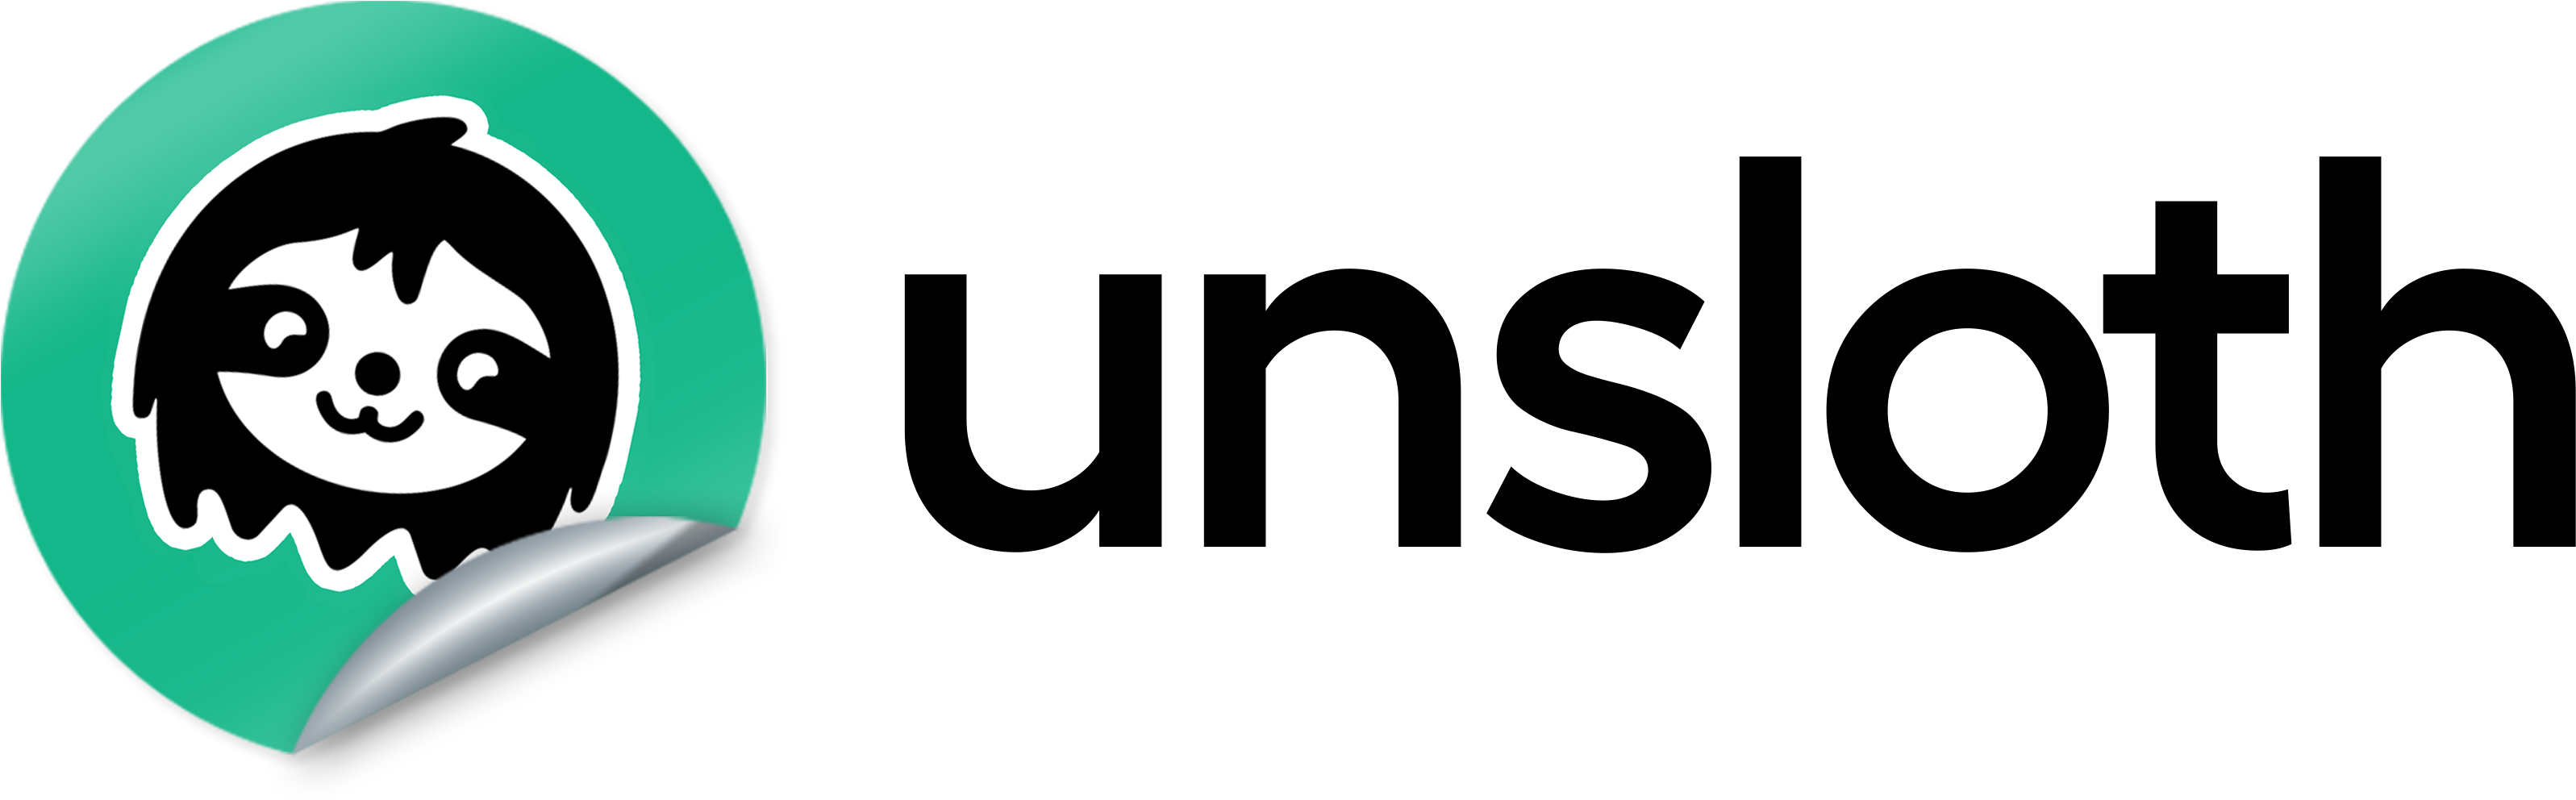

Unsloth is an opensource framework that provides a set of tools for efficient finetuning and reinforcement learning for various large language models (LLMs). 

Key Advtanges are:
+ Unsloth simplifies model training locally and on platforms like Google Colab and Kaggle.
+ The key advantage of Unsloth is their active role in fixing critical bugs in major models.
+ Supports full-finetuning, pretraining, 4-bit, 16-bit and 8-bit training.

>[!Note]
> This notebook is tested to work with following pinned versions only
> ``torch==2.6.0+cu124``
> ``transformers==4.55.2``
> ``datasets==3.6.0``
> ``trl==0.21.0``
> ``unsloth==2025.8.6``

In [21]:
import torch
import transformers
import datasets
import trl
import unsloth

In [22]:
print("versions::")
print(f"`torch=={torch.__version__}``")
print(f"`transformers=={transformers.__version__}``")
print(f"`datasets=={datasets.__version__}``")
print(f"`trl=={trl.__version__}``")
print(f"`unsloth=={unsloth.__version__}``")

versions::
`torch==2.6.0+cu124``
`transformers==4.55.2``
`datasets==3.6.0``
`trl==0.21.0``
`unsloth==2025.8.6``


## Imports

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!pip install pip3-autoremove
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
!pip install unsloth
!pip install --upgrade transformers==4.53.2 "huggingface_hub>=0.34.0" "datasets>=3.4.1,<4.0.0"

In [ ]:
!pip install unsloth_zoo
# restart notebook after this step

In [1]:
# Unsloth fixes to DPOTrainer
from unsloth import PatchDPOTrainer

PatchDPOTrainer()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Your Flash Attention 2 installation seems to be broken?
A possible explanation is you have a new CUDA version which isn't
yet compatible with FA2? Please file a ticket to Unsloth or FA2.
We shall now use Xformers instead, which does not have any performance hits!
We found this negligible impact by benchmarking on 1x A100.
🦥 Unsloth Zoo will now patch everything to make training faster!
Standard import failed for UnslothGKDTrainer: No module named 'UnslothGKDTrainer'. Using tempfile instead!


## Get Model Objects

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/zephyr-sft-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.8.6: Fast Mistral patching. Transformers: 4.55.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.422 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Prepare Preference Dataset

The DPO training process relies on a specific type of dataset, often called a _"preference dataset"_. This dataset is crucial for the model to learn what constitutes a _"good"_ or _"bad"_ response.

The data for DPO is structured as a collection of triplets, where each example consists of:

- A **prompt**: The initial input or instruction given to the model.

A **preferred response**: The response to the prompt that is considered "chosen" or "winning." This is the high-quality response that the model should learn to generate.

A **rejected response**: The response to the prompt that is considered "rejected" or "losing." This is a suboptimal or undesirable response that the model should learn to avoid.

In [3]:
import os
import re
from typing import List, Literal, Optional

from datasets import DatasetDict, concatenate_datasets, load_dataset, load_from_disk
from datasets.builder import DatasetGenerationError


DEFAULT_CHAT_TEMPLATE = "{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '<|user|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'system' %}\n{{ '<|system|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|assistant|>\n'  + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|assistant|>' }}\n{% endif %}\n{% endfor %}"


def apply_chat_template(
    example,
    tokenizer,
    task: Literal["sft", "generation", "rm", "dpo"] = "sft",
    assistant_prefix="<|assistant|>\n",
):
    def _strip_prefix(s, pattern):
        # Use re.escape to escape any special characters in the pattern
        return re.sub(f"^{re.escape(pattern)}", "", s)

    if task in ["sft", "generation"]:
        messages = example["messages"]
        # We add an empty system message if there is none
        if messages[0]["role"] != "system":
            messages.insert(0, {"role": "system", "content": ""})
        example["text"] = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True if task == "generation" else False,
        )
    elif task == "rm":
        if all(k in example.keys() for k in ("chosen", "rejected")):
            chosen_messages = example["chosen"]
            rejected_messages = example["rejected"]
            # We add an empty system message if there is none
            if chosen_messages[0]["role"] != "system":
                chosen_messages.insert(0, {"role": "system", "content": ""})
            if rejected_messages[0]["role"] != "system":
                rejected_messages.insert(0, {"role": "system", "content": ""})
            example["text_chosen"] = tokenizer.apply_chat_template(
                chosen_messages, tokenize=False
            )
            example["text_rejected"] = tokenizer.apply_chat_template(
                rejected_messages, tokenize=False
            )
        else:
            raise ValueError(
                f"Could not format example as dialogue for `rm` task! Require `[chosen, rejected]` keys but found {list(example.keys())}"
            )
    elif task == "dpo":
        if all(k in example.keys() for k in ("chosen", "rejected")):
            # Compared to reward modeling, we filter out the prompt, so the text is everything after the last assistant token
            prompt_messages = [
                [msg for msg in example["chosen"] if msg["role"] == "user"][0]
            ]
            # Insert system message
            if example["chosen"][0]["role"] != "system":
                prompt_messages.insert(0, {"role": "system", "content": ""})
            else:
                prompt_messages.insert(0, example["chosen"][0])
            # TODO: handle case where chosen/rejected also have system messages
            chosen_messages = example["chosen"][1:]
            rejected_messages = example["rejected"][1:]
            example["text_chosen"] = tokenizer.apply_chat_template(
                chosen_messages, tokenize=False
            )
            example["text_rejected"] = tokenizer.apply_chat_template(
                rejected_messages, tokenize=False
            )
            example["text_prompt"] = tokenizer.apply_chat_template(
                prompt_messages, tokenize=False, add_generation_prompt=True
            )
            example["text_chosen"] = _strip_prefix(
                example["text_chosen"], assistant_prefix
            )
            example["text_rejected"] = _strip_prefix(
                example["text_rejected"], assistant_prefix
            )
        else:
            raise ValueError(
                f"Could not format example as dialogue for `dpo` task! Require `[chosen, rejected]` keys but found {list(example.keys())}"
            )
    else:
        raise ValueError(
            f"Task {task} not supported, please ensure that the provided task is one of {['sft', 'generation', 'rm', 'dpo']}"
        )
    return example

In [4]:
from datasets import load_dataset
dataset = load_dataset("flytech/python-codes-25k", split = "train")
dataset

Dataset({
    features: ['output', 'instruction', 'input', 'text'],
    num_rows: 49626
})

In [5]:
dataset= dataset.rename_columns({
      'instruction': 'prompt',
      'output': 'rejected',
}).remove_columns(['input', 'text'])
dataset

Dataset({
    features: ['rejected', 'prompt'],
    num_rows: 49626
})

In [6]:
idx = 0
print(f"Prompt:\n {dataset[idx]['prompt']}")
print("-"*25)
print(f"Rejected:\n {dataset[idx]['rejected']}")

Prompt:
 Help me set up my daily to-do list!
-------------------------
Rejected:
 ```python
tasks = []
while True:
    task = input('Enter a task or type 'done' to finish: ')
    if task == 'done': break
    tasks.append(task)
print(f'Your to-do list for today: {tasks}')
```


In [7]:
import re
def extract_python_code(text):
  """
  Extracts text within ```python ``` delimited code blocks from a string.

  Args:
    text: The input string containing potentially code blocks.

  Returns:
    A list of strings, where each string is the content of a python code block.
  """
  pattern = r"```python(.*?)```"
  code_blocks = re.findall(pattern, text, re.DOTALL)
  return [block.strip() for block in code_blocks]

In [8]:
# Mapping method to remove non-code text and add DPO prefix
def add_prefix(example):
  clean_text = ' '.join(extract_python_code(example['rejected']))
  if len(clean_text)>0:
    example['chosen'] = '#This Model is Aligned using DPO\n to'+example['prompt']+'\n```python\n' + \
     clean_text+ '\n```[THE END]'
  else:
    example['chosen'] = "OOPS"
  return example

In [9]:
def apply_zephyr_pre_template(example):
  example['chosen'] = [{"content": example['prompt'],"role": 'user'},{"content": example['chosen'],"role":'assistant'}]
  example['rejected'] = [{"content": example['prompt'],"role": 'user'},{"content": example['rejected'],"role":'assistant'}]
  return example

In [10]:
# cleanup the dataset
updated_dataset = dataset.map(add_prefix).filter(lambda example: example['chosen']!="OOPS")

Map:   0%|          | 0/49626 [00:00<?, ? examples/s]

Filter:   0%|          | 0/49626 [00:00<?, ? examples/s]

In [11]:
updated_dataset = updated_dataset.map(apply_zephyr_pre_template)

Map:   0%|          | 0/43648 [00:00<?, ? examples/s]

In [12]:
idx = 1001
print(f"Prompt:\n {updated_dataset[idx]['prompt']}")
print("-"*25)
print(f"Chosen:\n {updated_dataset[idx]['chosen']}")
print("-"*25)
print(f"Rejected:\n {updated_dataset[idx]['rejected']}")

Prompt:
 Perform basic image manipulation using PIL
-------------------------
Chosen:
 [{'content': 'Perform basic image manipulation using PIL', 'role': 'user'}, {'content': "#This Model is Aligned using DPO\n toPerform basic image manipulation using PIL\n```python\nfrom PIL import Image\nimg = Image.open('image.jpg')\nimg_rotated = img.rotate(90)\nimg_rotated.save('image_rotated.jpg')\n```[THE END]", 'role': 'assistant'}]
-------------------------
Rejected:
 [{'content': 'Perform basic image manipulation using PIL', 'role': 'user'}, {'content': "```python\nfrom PIL import Image\nimg = Image.open('image.jpg')\nimg_rotated = img.rotate(90)\nimg_rotated.save('image_rotated.jpg')\n```", 'role': 'assistant'}]


In [13]:
chat_template_dataset = updated_dataset.map(
    apply_chat_template,
    fn_kwargs = {"tokenizer": tokenizer, "task": "dpo"},
    num_proc = 12,
    remove_columns = ['prompt'],
    desc = "Formatting comparisons with prompt template",
)

Formatting comparisons with prompt template (num_proc=12):   0%|          | 0/43648 [00:00<?, ? examples/s]

In [14]:
chat_template_dataset = chat_template_dataset.remove_columns(['rejected', 'chosen']).rename_columns(
        {"text_prompt": "prompt", "text_chosen": "chosen", "text_rejected": "rejected"}
    )

In [15]:
chat_template_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 43648
})

In [16]:
idx = 1001
print(f"Prompt:\n {chat_template_dataset[idx]['prompt']}")
print("-"*25)
print(f"Chosen:\n {chat_template_dataset[idx]['chosen']}")
print("-"*25)
print(f"Rejected:\n {chat_template_dataset[idx]['rejected']}")

Prompt:
 <|system|>
</s>
<|user|>
Perform basic image manipulation using PIL</s>
<|assistant|>

-------------------------
Chosen:
 #This Model is Aligned using DPO
 toPerform basic image manipulation using PIL
```python
from PIL import Image
img = Image.open('image.jpg')
img_rotated = img.rotate(90)
img_rotated.save('image_rotated.jpg')
```[THE END]</s>

-------------------------
Rejected:
 ```python
from PIL import Image
img = Image.open('image.jpg')
img_rotated = img.rotate(90)
img_rotated.save('image_rotated.jpg')
```</s>



## Get PEFT Model

In [17]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0, # Currently only supports dropout = 0
    bias = "none",    # Currently only supports bias = "none"
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.8.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Prepare DPO Training Config

In [18]:
from transformers import TrainingArguments
from trl import DPOTrainer, DPOConfig
dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,
    args = DPOConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_ratio = 0.1,
        num_train_epochs = 2,
        learning_rate = 5e-6,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.0,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
    beta = 0.1,
    train_dataset = chat_template_dataset.select(range(2000)),
    tokenizer = tokenizer,
    max_length = 1024,
    max_prompt_length = 512,
)

Extracting prompt in train dataset (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
dpo_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 2 | Total steps = 500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160 of 7,409,504,256 (2.26% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss
1,0.693100,0.000000,0.000000,0.000000,0.000000,-239.965729,-139.436707,-2.303423,-1.941169,0,0,0,0
2,0.693100,0.000000,0.000000,0.000000,0.000000,-247.608398,-140.543091,-2.245943,-1.880666,No Log,No Log,No Log,No Log
3,0.672400,0.022605,-0.020106,0.625000,0.042711,-269.758942,-166.133026,-2.115137,-1.753203,No Log,No Log,No Log,No Log
4,0.698700,0.002429,0.012583,0.375000,-0.010154,-247.805237,-148.075348,-2.161259,-1.853205,No Log,No Log,No Log,No Log
5,0.674700,0.004361,-0.033091,0.875000,0.037453,-250.687988,-138.497192,-2.348929,-2.023144,No Log,No Log,No Log,No Log
6,0.689400,0.010227,0.001879,0.625000,0.008348,-249.570709,-148.348450,-2.177090,-1.836494,No Log,No Log,No Log,No Log
7,0.667600,0.032051,-0.020510,0.875000,0.052561,-260.936676,-150.881882,-2.309347,-2.000751,No Log,No Log,No Log,No Log
8,0.684500,0.038234,0.020018,0.625000,0.018216,-260.075134,-144.791580,-2.362945,-2.078710,No Log,No Log,No Log,No Log
9,0.641700,0.090032,-0.016102,1.000000,0.106135,-239.045044,-138.966370,-2.240598,-1.851990,No Log,No Log,No Log,No Log
10,0.621400,0.113215,-0.037247,1.000000,0.150462,-237.007751,-129.838593,-2.323799,-1.935332,No Log,No Log,No Log,No Log


TrainOutput(global_step=500, training_loss=0.02220532775127208, metrics={'train_runtime': 1444.0821, 'train_samples_per_second': 2.77, 'train_steps_per_second': 0.346, 'total_flos': 0.0, 'train_loss': 0.02220532775127208, 'epoch': 2.0})

### Save and Push to HF-Hub

In [20]:
dpo_trainer.save_model()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
dpo_trainer.push_to_hub("zephyr-sft-dpo-4bit-unsloth",
                        #token="hf_"
                        )

## Time to Check Alignment

In [21]:
# Generate Streaming Output
from transformers import TextStreamer

In [22]:
test_idx = 3584
print(f"Prompt:\n {chat_template_dataset[test_idx]['prompt']}")
print("-"*25)
print(f"Chosen:\n {chat_template_dataset[test_idx]['chosen']}")
print("-"*25)
print(f"Rejected:\n {chat_template_dataset[test_idx]['rejected']}")

Prompt:
 <|system|>
</s>
<|user|>
Fix the code: def longest_common_prefix(arr_of_dictionaries):
 prefix = ''
 if len(arr_of_dictionaries) == 0:
 return prefix
 first_dict_keys = arr_of_dictionaries[0].keys()
 for i in range(len(list(first_dict_keys)[0])):
 char = list(first_dict_keys)[0][i]
 for dict in arr_of_dictionaries:
 if list(dict.keys())[0][i] != char:
 return prefix
 prefix += char
 return prefix</s>
<|assistant|>

-------------------------
Chosen:
 #This Model is Aligned using DPO
 toFix the code: def longest_common_prefix(arr_of_dictionaries):
 prefix = ''
 if len(arr_of_dictionaries) == 0:
 return prefix
 first_dict_keys = arr_of_dictionaries[0].keys()
 for i in range(len(list(first_dict_keys)[0])):
 char = list(first_dict_keys)[0][i]
 for dict in arr_of_dictionaries:
 if list(dict.keys())[0][i] != char:
 return prefix
 prefix += char
 return prefix
```python
def longest_common_prefix(arr_of_dictionaries):
 if len(arr_of_dictionaries) == 0:
 return ''
 keys = [set(d.keys())

In [23]:
messages = [
    {
        "role": "user",
        "content": chat_template_dataset[test_idx]['prompt']
    },
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)

In [24]:
_ = dpo_trainer.model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 500, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

Here's a possible fix for the given code:

```python
def longest_common_prefix(arr_of_dictionaries):
   if not arr_of_dictionaries:
       return ""

   prefix = ""
   for key in arr_of_dictionaries[0].keys():
       for I in range(min(len(key), len(arr_of_dictionaries[0][key])))):
           char = key[i]
           for dict in arr_of_dictionaries:
               if dict[key][i] != char:
                   return prefix
           prefix += char
       return prefix

   # If all keys have the same length, continue checking
   for key in arr_of_dictionaries[0].keys():
       for I in range(len(key)):
           char = key[i]
           for dict in arr_of_dictionaries:
               if I >= len(dict[key]):
                   return prefix
               if dict[key][i] != char:
                   return prefix
           prefix += char
   return prefix
```

The main issue with the original code is that it assumes that all keys in the first dictionary have the same length, which is not 